In [1]:
from cnn_model_3 import EmotionRecognition

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))  # Only if device_count > 0

train_loader = torch.load('train_dataloader_aug.pth', weights_only=False)
test_loader = torch.load('test_dataloader_aug.pth', weights_only=False)

True
1
NVIDIA GeForce RTX 2060


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmotionRecognition(nn.Module):
    def __init__(self):
        super(EmotionRecognition, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Dummy input to determine flatten size after conv layers
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 48, 48)
            dummy = self._forward_conv(dummy)
            self.flattened_size = dummy.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, 7)

    def _forward_conv(self, x):
        # Only the convolutional part, used for shape inference and forward
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [4]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        alpha: tensor of shape (num_classes,) for class weights
        gamma: focusing parameter
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # class weights
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # pt = probability of the true class
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [6]:
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
print(f"Using device: {device}")
model = EmotionRecognition().to(device)
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_loader.dataset.targets),
                                     y=train_loader.dataset.targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = FocalLoss(alpha=class_weights_tensor, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None



Using device: cuda


C:\Users\Korisnik\AppData\Local\Temp\ipykernel_10884\2626375699.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == "cuda" else None


In [7]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / total_samples, 100. * total_correct / total_samples

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [8]:
best_loss = float('inf')
patience = 10
epochs_no_improve = 0
num_epochs = 100
save_path = "best_model.pth"

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    labels, preds = evaluate(model, test_loader)
    test_acc = 100. * np.sum(preds == labels) / len(labels)

    scheduler.step()

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    # Early stopping
    if train_loss < best_loss:
        best_loss = train_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print("✅ Saved new best model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹ Early stopping triggered.")
            break

Training:   0%|          | 0/449 [00:00<?, ?it/s]C:\Users\Korisnik\AppData\Local\Temp\ipykernel_10884\4020488208.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):



Epoch 1/100
Train Loss: 1.6070, Train Acc: 16.23% | Test Acc: 17.83%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 2/100
Train Loss: 1.3645, Train Acc: 17.30% | Test Acc: 23.79%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 3/100
Train Loss: 1.3438, Train Acc: 18.93% | Test Acc: 19.92%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 4/100
Train Loss: 1.3355, Train Acc: 18.82% | Test Acc: 20.21%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 5/100
Train Loss: 1.3303, Train Acc: 18.69% | Test Acc: 20.05%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 6/100
Train Loss: 1.3096, Train Acc: 19.17% | Test Acc: 23.03%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 7/100
Train Loss: 1.3111, Train Acc: 19.31% | Test Acc: 21.72%
Learning Rate: 0.001000



Epoch 8/100
Train Loss: 1.2796, Train Acc: 19.27% | Test Acc: 22.01%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 9/100
Train Loss: 1.2729, Train Acc: 19.66% | Test Acc: 21.30%
Learning Rate: 0.001000
✅ Saved new best model.



Epoch 10/100
Train Loss: 1.2651, Train Acc: 15.43% | Test Acc: 15.32%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 11/100
Train Loss: 1.2413, Train Acc: 18.93% | Test Acc: 28.35%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 12/100
Train Loss: 1.2211, Train Acc: 22.43% | Test Acc: 31.44%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 13/100
Train Loss: 1.2135, Train Acc: 22.35% | Test Acc: 35.92%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 14/100
Train Loss: 1.1827, Train Acc: 24.98% | Test Acc: 37.11%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 15/100
Train Loss: 1.1494, Train Acc: 26.38% | Test Acc: 36.18%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 16/100
Train Loss: 1.1319, Train Acc: 26.97% | Test Acc: 36.01%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 17/100
Train Loss: 1.0917, Train Acc: 30.38% | Test Acc: 41.78%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 18/100
Train Loss: 1.0575, Train Acc: 32.07% | Test Acc: 38.79%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 19/100
Train Loss: 1.0139, Train Acc: 36.22% | Test Acc: 44.11%
Learning Rate: 0.000500
✅ Saved new best model.



Epoch 20/100
Train Loss: 0.9848, Train Acc: 38.37% | Test Acc: 45.85%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 21/100
Train Loss: 0.9464, Train Acc: 40.50% | Test Acc: 48.06%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 22/100
Train Loss: 0.9265, Train Acc: 41.08% | Test Acc: 47.23%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 23/100
Train Loss: 0.9058, Train Acc: 42.29% | Test Acc: 48.75%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 24/100
Train Loss: 0.8847, Train Acc: 43.55% | Test Acc: 49.43%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 25/100
Train Loss: 0.8816, Train Acc: 43.53% | Test Acc: 50.15%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 26/100
Train Loss: 0.8616, Train Acc: 44.39% | Test Acc: 50.47%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 27/100
Train Loss: 0.8476, Train Acc: 44.74% | Test Acc: 51.91%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 28/100
Train Loss: 0.8327, Train Acc: 45.94% | Test Acc: 51.43%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 29/100
Train Loss: 0.8110, Train Acc: 45.97% | Test Acc: 51.57%
Learning Rate: 0.000250
✅ Saved new best model.



Epoch 30/100
Train Loss: 0.8038, Train Acc: 46.74% | Test Acc: 52.24%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 31/100
Train Loss: 0.7669, Train Acc: 48.05% | Test Acc: 51.94%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 32/100
Train Loss: 0.7622, Train Acc: 48.35% | Test Acc: 53.79%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 33/100
Train Loss: 0.7551, Train Acc: 49.04% | Test Acc: 53.13%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 34/100
Train Loss: 0.7440, Train Acc: 49.49% | Test Acc: 53.65%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 35/100
Train Loss: 0.7259, Train Acc: 49.31% | Test Acc: 54.14%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 36/100
Train Loss: 0.7240, Train Acc: 50.24% | Test Acc: 54.71%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 37/100
Train Loss: 0.7073, Train Acc: 50.32% | Test Acc: 53.73%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 38/100
Train Loss: 0.7123, Train Acc: 50.25% | Test Acc: 54.81%
Learning Rate: 0.000125



Epoch 39/100
Train Loss: 0.7019, Train Acc: 50.79% | Test Acc: 54.82%
Learning Rate: 0.000125
✅ Saved new best model.



Epoch 40/100
Train Loss: 0.6954, Train Acc: 50.98% | Test Acc: 55.41%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 41/100
Train Loss: 0.6803, Train Acc: 52.19% | Test Acc: 55.64%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 42/100
Train Loss: 0.6757, Train Acc: 52.05% | Test Acc: 54.95%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 43/100
Train Loss: 0.6693, Train Acc: 52.20% | Test Acc: 55.43%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 44/100
Train Loss: 0.6554, Train Acc: 52.67% | Test Acc: 56.20%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 45/100
Train Loss: 0.6549, Train Acc: 53.12% | Test Acc: 55.85%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 46/100
Train Loss: 0.6496, Train Acc: 52.90% | Test Acc: 56.49%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 47/100
Train Loss: 0.6525, Train Acc: 52.75% | Test Acc: 56.06%
Learning Rate: 0.000063



Epoch 48/100
Train Loss: 0.6456, Train Acc: 53.14% | Test Acc: 56.46%
Learning Rate: 0.000063
✅ Saved new best model.



Epoch 49/100
Train Loss: 0.6479, Train Acc: 53.27% | Test Acc: 55.84%
Learning Rate: 0.000063



Epoch 50/100
Train Loss: 0.6359, Train Acc: 53.58% | Test Acc: 56.09%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 51/100
Train Loss: 0.6420, Train Acc: 53.48% | Test Acc: 56.19%
Learning Rate: 0.000031



Epoch 52/100
Train Loss: 0.6239, Train Acc: 54.17% | Test Acc: 56.85%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 53/100
Train Loss: 0.6253, Train Acc: 53.85% | Test Acc: 56.38%
Learning Rate: 0.000031



Epoch 54/100
Train Loss: 0.6304, Train Acc: 54.13% | Test Acc: 56.51%
Learning Rate: 0.000031



Epoch 55/100
Train Loss: 0.6230, Train Acc: 54.29% | Test Acc: 56.38%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 56/100
Train Loss: 0.6247, Train Acc: 53.61% | Test Acc: 57.17%
Learning Rate: 0.000031



Epoch 57/100
Train Loss: 0.6198, Train Acc: 54.62% | Test Acc: 56.83%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 58/100
Train Loss: 0.6152, Train Acc: 54.36% | Test Acc: 57.13%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 59/100
Train Loss: 0.6150, Train Acc: 54.47% | Test Acc: 56.66%
Learning Rate: 0.000031
✅ Saved new best model.



Epoch 60/100
Train Loss: 0.6064, Train Acc: 54.24% | Test Acc: 56.94%
Learning Rate: 0.000016
✅ Saved new best model.



Epoch 61/100
Train Loss: 0.6090, Train Acc: 54.62% | Test Acc: 57.09%
Learning Rate: 0.000016



Epoch 62/100
Train Loss: 0.6081, Train Acc: 54.73% | Test Acc: 56.78%
Learning Rate: 0.000016



Epoch 63/100
Train Loss: 0.6053, Train Acc: 54.72% | Test Acc: 57.33%
Learning Rate: 0.000016
✅ Saved new best model.



Epoch 64/100
Train Loss: 0.6075, Train Acc: 54.70% | Test Acc: 57.09%
Learning Rate: 0.000016



Epoch 65/100
Train Loss: 0.6026, Train Acc: 54.85% | Test Acc: 57.02%
Learning Rate: 0.000016
✅ Saved new best model.



Epoch 66/100
Train Loss: 0.6088, Train Acc: 54.84% | Test Acc: 57.12%
Learning Rate: 0.000016



Epoch 67/100
Train Loss: 0.5982, Train Acc: 55.25% | Test Acc: 56.97%
Learning Rate: 0.000016
✅ Saved new best model.



Epoch 68/100
Train Loss: 0.5972, Train Acc: 55.31% | Test Acc: 56.85%
Learning Rate: 0.000016
✅ Saved new best model.



Epoch 69/100
Train Loss: 0.6000, Train Acc: 54.83% | Test Acc: 57.20%
Learning Rate: 0.000016



Epoch 70/100
Train Loss: 0.5907, Train Acc: 55.55% | Test Acc: 57.19%
Learning Rate: 0.000008
✅ Saved new best model.



Epoch 71/100
Train Loss: 0.5937, Train Acc: 55.56% | Test Acc: 57.08%
Learning Rate: 0.000008



Epoch 72/100
Train Loss: 0.5919, Train Acc: 55.42% | Test Acc: 56.95%
Learning Rate: 0.000008



Epoch 73/100
Train Loss: 0.5909, Train Acc: 55.45% | Test Acc: 57.16%
Learning Rate: 0.000008



Epoch 74/100
Train Loss: 0.5879, Train Acc: 55.77% | Test Acc: 56.90%
Learning Rate: 0.000008
✅ Saved new best model.



Epoch 75/100
Train Loss: 0.5862, Train Acc: 55.36% | Test Acc: 57.20%
Learning Rate: 0.000008
✅ Saved new best model.



Epoch 76/100
Train Loss: 0.5980, Train Acc: 55.36% | Test Acc: 56.92%
Learning Rate: 0.000008



Epoch 77/100
Train Loss: 0.5866, Train Acc: 55.31% | Test Acc: 57.08%
Learning Rate: 0.000008



Epoch 78/100
Train Loss: 0.5866, Train Acc: 55.73% | Test Acc: 57.22%
Learning Rate: 0.000008



Epoch 79/100
Train Loss: 0.5853, Train Acc: 55.61% | Test Acc: 57.11%
Learning Rate: 0.000008
✅ Saved new best model.



Epoch 80/100
Train Loss: 0.5895, Train Acc: 55.78% | Test Acc: 57.26%
Learning Rate: 0.000004



Epoch 81/100
Train Loss: 0.5904, Train Acc: 55.49% | Test Acc: 56.94%
Learning Rate: 0.000004



Epoch 82/100
Train Loss: 0.5925, Train Acc: 55.50% | Test Acc: 57.01%
Learning Rate: 0.000004



Epoch 83/100
Train Loss: 0.5867, Train Acc: 55.63% | Test Acc: 57.33%
Learning Rate: 0.000004



Epoch 84/100
Train Loss: 0.5862, Train Acc: 55.61% | Test Acc: 57.33%
Learning Rate: 0.000004



Epoch 85/100
Train Loss: 0.5923, Train Acc: 55.70% | Test Acc: 57.22%
Learning Rate: 0.000004



Epoch 86/100
Train Loss: 0.5922, Train Acc: 56.07% | Test Acc: 57.05%
Learning Rate: 0.000004



Epoch 87/100
Train Loss: 0.5870, Train Acc: 55.30% | Test Acc: 57.40%
Learning Rate: 0.000004



Epoch 88/100
Train Loss: 0.5884, Train Acc: 55.48% | Test Acc: 57.33%
Learning Rate: 0.000004



Epoch 89/100
Train Loss: 0.5869, Train Acc: 55.61% | Test Acc: 57.06%
Learning Rate: 0.000004
⏹ Early stopping triggered.


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Final evaluation
model.load_state_dict(torch.load(save_path))
model.eval()
labels, preds = evaluate(model, test_loader)

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=emotion_labels))
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


Classification Report:
              precision    recall  f1-score   support

       Angry       0.44      0.52      0.47       958
     Disgust       0.37      0.68      0.48       111
        Fear       0.39      0.30      0.34      1024
       Happy       0.89      0.70      0.78      1774
         Sad       0.55      0.56      0.56      1233
    Surprise       0.45      0.48      0.46      1247
     Neutral       0.66      0.82      0.73       831

    accuracy                           0.57      7178
   macro avg       0.53      0.58      0.55      7178
weighted avg       0.59      0.57      0.57      7178

Confusion Matrix:
[[ 497   50  100   26   98  149   38]
 [  20   76    5    1    3    3    3]
 [ 164   20  307   26  109  226  172]
 [ 122    9   62 1245  142  118   76]
 [ 122   13   88   48  696  231   35]
 [ 187   32  156   36  206  599   31]
 [  27    5   69   22   17   12  679]]


Classification Report:
              precision    recall  f1-score   support

       Angry       0.44      0.52      0.47       958
     Disgust       0.37      0.68      0.48       111
        Fear       0.39      0.30      0.34      1024
       Happy       0.89      0.70      0.78      1774
         Sad       0.55      0.56      0.56      1233
    Surprise       0.45      0.48      0.46      1247
     Neutral       0.66      0.82      0.73       831

    accuracy                           0.57      7178
   macro avg       0.53      0.58      0.55      7178
weighted avg       0.59      0.57      0.57      7178

Confusion Matrix:
[[ 497   50  100   26   98  149   38]
 [  20   76    5    1    3    3    3]
 [ 164   20  307   26  109  226  172]
 [ 122    9   62 1245  142  118   76]
 [ 122   13   88   48  696  231   35]
 [ 187   32  156   36  206  599   31]
 [  27    5   69   22   17   12  679]]


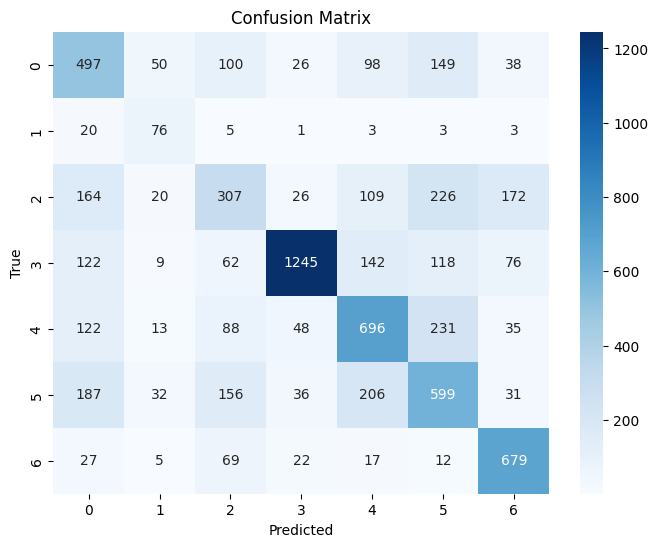

In [14]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


# Containers for predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()